# Grid Search SARIMA

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline  

import pandas as pd
import numpy as np
from numpy import array
import datetime
import statsmodels.api as sm  
import matplotlib.pyplot as plt
import itertools

from dataset.data import deutsches_wetter_dienst
from scripts.grid import grid_search

## Load Official Weather Data Observations

readings every hour

In [3]:
df = deutsches_wetter_dienst(2013, 2016, '/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt')
df.head()

,D_Temp,D_Humi
datetime,,
2013-01-01 00:00:00,8.4,70.0
2013-01-01 01:00:00,8.4,70.0
2013-01-01 02:00:00,8.4,69.0
2013-01-01 03:00:00,8.7,68.0
2013-01-01 04:00:00,8.5,69.0


In [4]:
# compute daily average : fill in nans created during resampling with the nearest value
timestep = 'D'
df = df.resample(timestep).nearest()
df.head()

,D_Temp,D_Humi
datetime,,
2013-01-01,8.4,70.0
2013-01-02,3.9,85.0
2013-01-03,5.9,78.0
2013-01-04,8.8,90.0
2013-01-05,8.6,94.0


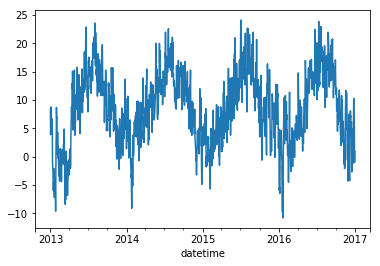

In [7]:
# select single variable for building model
sensor = 'D_Temp'
df[sensor].plot()

In [8]:
data = np.array(df[sensor])
len(data)

1461

## SARIMA Hyperparameters and Parsimony Principle
This model has hyperparameters that control the nature of the model performed for the series, trend and seasonality, specifically:

* order: A tuple p, d, and q parameters for the modeling of the trend.
* sesonal_order: A tuple of P, D, Q, and m parameters for the modeling the seasonality
* trend: A parameter for controlling a model of the deterministic trend as one of:
    * ‘n’ : no trend
    * ’c’: constant  
    * ’t’: linear 
    * ’ct’: constant with linear trend  

Selecing Hyperparameters Manually 

Rules for SARIMA model selection from ACF/PACF plots
These are all rule of thumbs, not an exact science for picking the number of each parameters in SARIMA(p,d,q)(P,D,Q)[S]. It is an art in picking good parameters from the ACF/PACF plots. The following rules also apply to ARMA and ARIMA models.

Identifying the order of differencing:

d=0 if the series has no visible trend or ACF at all lags is low.

d≥1 if the series has visible trend or positive ACF values out to a high number of lags.

Note: if after applying differencing to the series and the ACF at lag 1 is -0.5 or more negative the series may be overdifferenced.

Note: If you find the best d to be d=1 then the original series has a constant trend. A model with d=2 assumes that the original series has a time-varying trend.

Identifying the number of AR and MA terms
p is equal to the first lag where the PACF value is above the significance level.

q is equal to the first lag where the ACF value is above the significance level.

Identifying the seasonal part of the model:

S is equal to the ACF lag with the highest value (typically at a high lag).

D=1 if the series has a stable seasonal pattern over time.

D=0 if the series has an unstable seasonal pattern over time.

Rule of thumb: d+D≤2

P≥1 if the ACF is positive at lag S, else P=0.

Q≥1 if the ACF is negative at lag S, else Q=0.

Rule of thumb: P+Q≤2

https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima

## SARIMA Hyperparameters Using Grid Search:

Grid search is used to help us select hyperparameters. In a grid search, we train and evaluate a model on all possible configurations of the hyperparameters. If you have many models to build automating the hyperparameter selection will save time.

In [21]:
def sarima_configs(seasonal=[12]):
    models = list()
    # define config lists
    p = [0, 1]
    d = [0]
    q = [0, 1]
    t = ['c','n']
    P = [0, 1]
    D = [0]
    Q = [0, 1]
    m = seasonal   
    non_seasonal = itertools.product(p, d, q)
    seasonal = itertools.product(P, D, Q, m)
    result = []
    for tup in itertools.product(non_seasonal, seasonal, t):
        result.append(list(tup))
    return result           

In [39]:
configs = sarima_configs()
print('The number of SARIMA hyperparameter configurations is: {}'.format(len(configs)))

The number of SARIMA hyperparameter configurations is: 32


## Training and Hyperparameter Evaluation
Use subset of the data for training and the last 'lookahead' elements of the the training set for  hyperparameter evaluation.

Each configuration of the hyperparameter is evaluated using 'lookahead' steps beyond original training set.  We incrementally train a model and  make a forecast for a timestep that is one time step ahead. 

After a timestep is used to evaluate a prediction it is incorporated into the training set. Performance is recored for each hyperparameter configuration for each lookahead and the best performing configuration is used for building the final model.

We can avoid overfitting by not building overly complex models using simple rule of thumb. One rule for SARIMA is the Parsimony Principle in which sum of hyperparameter values: p+d+q+P+D+Q ≤ 6. Such rules can be used to constrains the value of each hyperparameter.

In [22]:
mintrain = df.index.get_loc('2013-01-01')
maxtrain = df.index.get_loc('2014-01-15')
lookahead_validation = 20
trainval = data[mintrain:maxtrain] 

In [17]:
# grid search
scores = grid_search(trainval, configs, n_validation)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 12), 'c']] 3.595
 > Model[[(0, 0, 1), (0, 0, 0, 12), 'c']] 2.942
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'c']] 3.524
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'c']] 3.729
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'c']] 3.143
 > Model[[(0, 0, 1), (1, 0, 0, 12), 'c']] 3.084
 > Model[[(0, 0, 1), (0, 0, 1, 12), 'c']] 3.038
 > Model[[(1, 0, 0), (0, 0, 0, 12), 'c']] 3.557
 > Model[[(1, 0, 0), (0, 0, 1, 12), 'c']] 3.586
 > Model[[(1, 0, 0), (1, 0, 0, 12), 'c']] 3.586
 > Model[[(0, 0, 1), (1, 0, 1, 12), 'c']] 2.778
 > Model[[(1, 0, 1), (0, 0, 0, 12), 'c']] 3.446
 > Model[[(1, 0, 0), (1, 0, 1, 12), 'c']] 3.576
 > Model[[(1, 0, 1), (0, 0, 1, 12), 'c']] 3.454
 > Model[[(1, 0, 1), (1, 0, 0, 12), 'c']] 3.455
 > Model[[(1, 0, 1), (1, 0, 1, 12), 'c']] 3.452
done
[(0, 0, 1), (1, 0, 1, 12), 'c'] 2.7784562436352265
[(0, 0, 1), (0, 0, 0, 12), 'c'] 2.941626357120193
[(0, 0, 1), (0, 0, 1, 12), 'c'] 3.0381449315261757


# Build Model and Predict

In [47]:
start = '2013-01-01'
maxtrain = '2014-01-15'

sarima = sm.tsa.statespace.SARIMAX(df['D_Temp'].loc[mintrain:'2014-01-15'],trend='c', order=(0,0,1), seasonal_order=(1,0,1,12) )
model = sarima.fit(disp=True)

In [48]:
lookahead_prediction = 10
forecast = model.forecast(lookahead_prediction)

In [49]:
forecast

2014-01-16    1.821146
2014-01-17    5.479348
2014-01-18    5.859853
2014-01-19    7.444588
2014-01-20    7.232000
2014-01-21    6.561005
2014-01-22    6.290505
2014-01-23    4.957075
2014-01-24    5.122824
2014-01-25    2.482651
Freq: D, dtype: float64

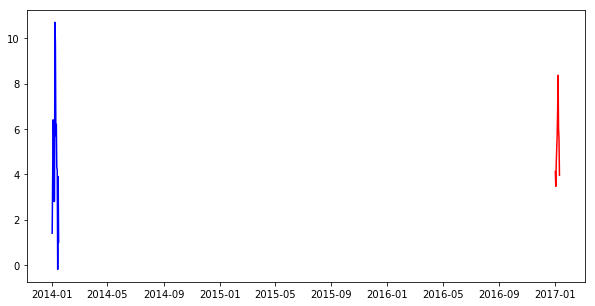

In [45]:
plt.figure(figsize= (10,5))
plt.plot(forecast, 'r')
plt.plot(df['D_Temp'].loc['2014-01-01':'2014-01-15'], 'b')
#plt.title('RMSE')

Cons: Depending on computing resources, grid search make take a while when if your search space is large. Here we limit the search to 16 different configurations. Also, optimal results obtained with grid search may not be the best and should be compared with manual hyperparameter selection.